# Load images dataset

on suit avec ce lien _https://www.tensorflow.org/tutorials/load_data/images_


on utilise le tuto à cette adresse [LIEN](https://stackoverflow.com/questions/57443122/how-to-load-images-in-google-colab-notebook-using-tensorflow-from-mounted-google)

_ne pas relancer la cellule sur un autre ordi que celui de guillaume_


In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import pathlib



In [3]:
# Mount Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load les images 

- Telecharge les images depuis Drive 
- Unzip l'archive
- Place tout dans ```/content/ai_ready/images```


In [4]:
!unzip -q '/content/drive/MyDrive/Hackathon/ai_ready.zip'


## PIL Load

Utilise PIL pour avoir un dataset d'entrée plus facile à manipuler pour le système (et mieux comprendre le fonctionnement)


In [5]:
import PIL
import pandas as pd


In [ ]:
# Loading a single img as a numpy array

test = PIL.Image.open('/content/ai_ready/images/silos_256-0-0--6-14--19-28655.png')
img_data = np.asarray(test)

# display img
print(img_data[:10])
display(test)


Pretty long to re-run every time

Gives :
- X_train = Training Dataset
- Y_train = Training Dataset Expected Results
- X_val = Validating Dataset
- Y_val = Validating Dataset Expected Results

In [6]:
# Loading all img as a numpy array in the INPUT X

path = '/content/ai_ready/'

df = pd.read_csv(path+'x-ai_data.csv')

X_train = []
X_val = []
Y_train = []
Y_val = []

for i in range(df.shape[0]):

  # Split in training and validation
  if df.loc[i]['split']=='validation':
    X_val.append(np.asarray(PIL.Image.open(path+'images/'+df.loc[i]['filename'])))
    Y_val.append(df.loc[i]['class'])
  else:
    # consider 'test' as 'training' as recommended by advisor
    X_train.append(np.asarray(PIL.Image.open(path+'images/'+df.loc[i]['filename'])))
    Y_train.append(df.loc[i]['class'])




In [7]:
# Convert to numpy array to INPUT in model 

X_train = np.array(X_train)
Y_train = np.array(Y_train)

X_val = np.array(X_val)
Y_val = np.array(Y_val)

print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)


(1599, 256, 256, 3)
(1599,)
(400, 256, 256, 3)
(400,)


--- 

# Travail sur modele

Nouvelle Regle pour l'importation avec des arrays numpy

Utilisation de la fonction suivante :
[LINK]()

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, Y_val))


Shuffle des DATASET

In [9]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 2000

train_ds = train_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)


Constantes utiles :



In [10]:
img_width = 256
img_height = 256

input_shape = X_train.shape

## Modèles Intermédiaires

Petits modèles utiles pour ne pas réécrire trop de code :

Prétraitement + Augmentation du Dataset



In [11]:
resize_and_rescale = tf.keras.Sequential([
  keras.layers.Resizing(img_width, img_height),
  keras.layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  keras.layers.RandomFlip("horizontal_and_vertical"),
  keras.layers.RandomRotation(0.05,fill_mode='reflect',),
  keras.layers.RandomContrast(0.2)
])

In [12]:
resize_and_rescale.build(input_shape)
data_augmentation.build(input_shape)

## Modèle Test

Modèle en cours d'optimisation

- Utilise des modèles intermédiaires pour resize et rescale
- Utilise de l'augmentation forcée de DATA
- Basé sur la partie descendante du U dans cet [article](https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5)

In [ ]:
model_test = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    tf.keras.layers.Conv2D(16,(3,3),activation='relu', padding='same'),
    tf.keras.layers.Conv2D(16,(3,3),activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(32,(3,3),activation='relu', padding='same'),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.MaxPool2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

### Build + Launch by hand 

In [ ]:
model2.build(input_shape)
model2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 sequential_4 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_22 (Conv2D)          (1599, 256, 256, 16)      448       
                                                                 
 conv2d_23 (Conv2D)          (1599, 256, 256, 16)      2320      
                                                                 
 max_pooling2d_13 (MaxPoolin  (1599, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 dropout_11 (Dropout)        (1599, 128, 128, 16)      0         
                                                      

In [ ]:
model2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [ ]:
nb_epoch = 50

history = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs = nb_epoch
)

Epoch 1/50
50/50 [==============================] - 7s 104ms/step - loss: 0.7082 - accuracy: 0.5516 - val_loss: 0.6944 - val_accuracy: 0.5150
Epoch 2/50
50/50 [==============================] - 5s 101ms/step - loss: 0.6928 - accuracy: 0.5153 - val_loss: 0.6934 - val_accuracy: 0.4850
Epoch 3/50
50/50 [==============================] - 5s 101ms/step - loss: 0.6891 - accuracy: 0.5435 - val_loss: 0.6870 - val_accuracy: 0.5875
Epoch 4/50
50/50 [==============================] - 5s 101ms/step - loss: 0.6858 - accuracy: 0.5679 - val_loss: 0.6941 - val_accuracy: 0.5150
Epoch 5/50
50/50 [==============================] - 5s 102ms/step - loss: 0.6831 - accuracy: 0.5629 - val_loss: 0.6961 - val_accuracy: 0.5150
Epoch 6/50
50/50 [==============================] - 5s 101ms/step - loss: 0.6970 - accuracy: 0.4972 - val_loss: 0.6936 - val_accuracy: 0.5150
Epoch 7/50
50/50 [==============================] - 5s 100ms/step - loss: 0.6949 - accuracy: 0.5041 - val_loss: 0.6933 - val_accuracy: 0.4850
Epoch 

--- 
### Quick Builder and Launcher for model

In [13]:
def builder(model):
  model.build(input_shape)
  model.summary()
  model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])


In [14]:
def AUC_builder(model):
  model.build(input_shape)
  model.summary()
  model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics= [tf.keras.metrics.BinaryAccuracy(),
              tf.keras.metrics.FalsePositives(),
              tf.keras.metrics.FalseNegatives(),
              tf.keras.metrics.AUC()])


In [15]:
def launcher(model, n):
  history = model.fit(train_ds, 
                       validation_data=val_ds, 
                       epochs = n)
  return history

In [16]:
def model_plot(history):
  plt.rcParams['figure.figsize'] = [20, 9]
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0.5, 1])
  plt.legend(loc='lower right')

In [17]:
def AUC_model_plot(history):

  # shortcut to create history with dataset
  n1 = 1599
  n2 = 400

  plt.rcParams['figure.figsize'] = [20, 9]

  for key in history.keys():
    if (('false' in key) or ('true' in key)) and (not ('val' in key)):
      plt.plot(np.array(history[key])/n1, label=key)
    elif (('false' in key) or ('true' in key)) and ('val' in key):
      plt.plot(np.array(history[key])/n2, label=key)
    elif (key[-4:]=='loss'):
      pass
    else:
      plt.plot(history[key], label=key)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0, 1])
  plt.legend(loc='lower right')

In [18]:
def model_plot_bis(history):
  plt.rcParams['figure.figsize'] = [20, 9]
  plt.plot(history['accuracy'], label='accuracy')
  plt.plot(history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0.5, 1])
  plt.legend(loc='lower right')

In [19]:
def save_history(history, path,name):
   hist_df = pd.DataFrame(history.history) 
   # save to json:  
   hist_json_file = path + name
   with open(hist_json_file, mode='w') as f:
     hist_df.to_json(f)

In [20]:
def save_history(history, path, name):
  np.save(path + name ,history.history)

In [21]:
def load_history(path):
  return(np.load(path,allow_pickle='TRUE').item())

In [22]:
# reset plot parameters

plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

### Quick TEST

In [ ]:
###### BUILD MODEL ######

AUC_builder(model_test)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (1599, 256, 256, 16)      448       
                                                                 
 conv2d_5 (Conv2D)           (1599, 256, 256, 16)      2320      
                                                                 
 max_pooling2d_3 (MaxPooling  (1599, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (1599, 128, 128, 16)      0         
                                                      

In [ ]:
###### LAUNCH MODEL ######

n = 70
history = launcher(model_test, n)

Epoch 1/70
50/50 [==============================] - 7s 98ms/step - loss: 0.7312 - binary_accuracy: 0.5197 - false_positives_2: 662.0000 - false_negatives_2: 106.0000 - auc_2: 0.6022 - val_loss: 0.6883 - val_binary_accuracy: 0.5850 - val_false_positives_2: 160.0000 - val_false_negatives_2: 6.0000 - val_auc_2: 0.7321
Epoch 2/70
50/50 [==============================] - 5s 90ms/step - loss: 0.6732 - binary_accuracy: 0.5891 - false_positives_2: 567.0000 - false_negatives_2: 90.0000 - auc_2: 0.6684 - val_loss: 0.6724 - val_binary_accuracy: 0.6450 - val_false_positives_2: 133.0000 - val_false_negatives_2: 9.0000 - val_auc_2: 0.7355
Epoch 3/70
50/50 [==============================] - 5s 90ms/step - loss: 0.6683 - binary_accuracy: 0.6385 - false_positives_2: 394.0000 - false_negatives_2: 184.0000 - auc_2: 0.6726 - val_loss: 0.6737 - val_binary_accuracy: 0.5775 - val_false_positives_2: 20.0000 - val_false_negatives_2: 149.0000 - val_auc_2: 0.7181
Epoch 4/70
50/50 [==============================]

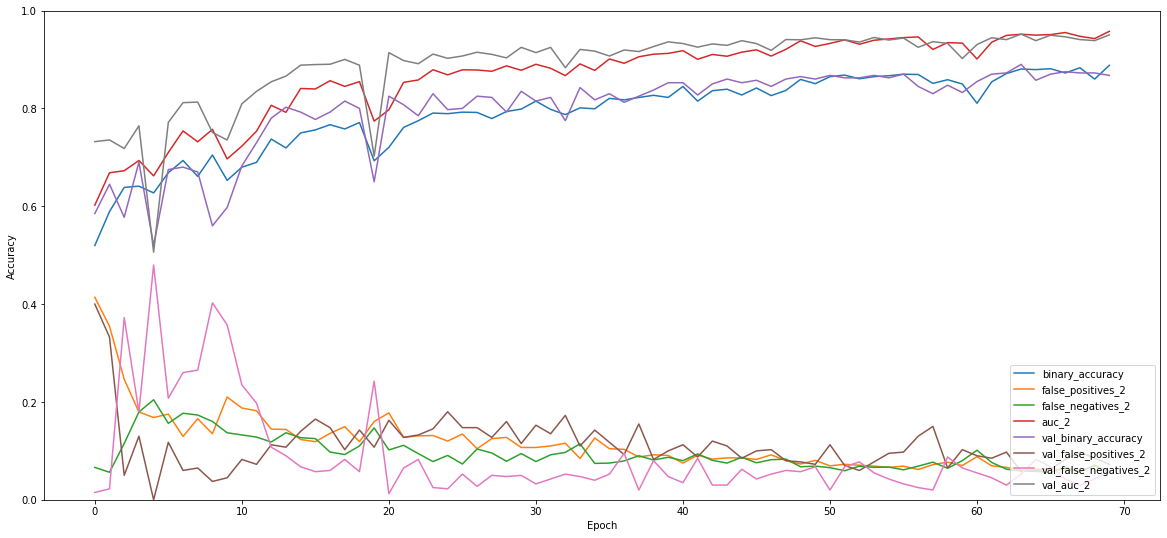

In [ ]:
###### PLOT MODEL ACCURACY ######

AUC_model_plot(history.history)

### Quick Export

In [ ]:
model_test.save('/media/AUC_modelY.h5', save_format='h5')

In [ ]:
save_history(history, '/media/history/','AUC_modelY_history')

In [28]:
history1 = load_history('/media/history/AUC_modelY_history.npy')

In [36]:
for key in history1.keys():
  print(key + ": " + str(np.round(history1[key][-1], decimals=2)))


loss: 0.41
binary_accuracy: 0.81
false_positives: 139.0
false_negatives: 164.0
auc: 0.9
val_loss: 0.35
val_binary_accuracy: 0.86
val_false_positives: 46.0
val_false_negatives: 12.0
val_auc: 0.93


In [41]:
def plotter(history):

  # shortcut to create history with dataset
  n1 = 1599
  n2 = 400

  plt.rcParams['figure.figsize'] = [20, 9]

  for key in history.keys():
    if not('val' in key):
      pass
    #if (('false' in key) or ('true' in key)) and (not ('val' in key)):
    # plt.plot(np.array(history[key])/n1, label=key)
    elif (('false' in key) or ('true' in key)) and ('val' in key):
      plt.plot(np.array(history[key])/n2, label=key)
    elif (key[-4:]=='loss'):
      pass
    else:
      plt.plot(history[key], label=key)
  plt.xlabel('Epoch')
  plt.ylabel('Ratio')
  plt.ylim([0, 1])
  plt.legend(loc='lower right')

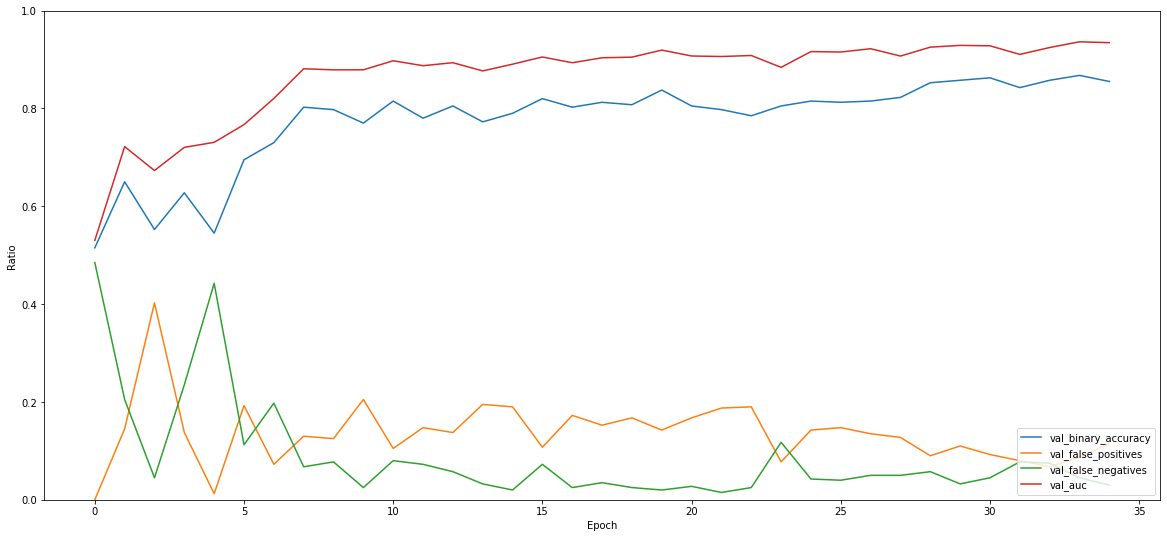

In [42]:
plotter(history1)

## Version Workspace 

### TO-DO Test

Ajouter des layers avec des conv pour avoir plus d'infos sur les images
Remplacer le combo **{Flatten + Dense}** par une Conv de la taille de l'image

Useful Link

_tips for optimizing performances_

- https://stackoverflow.com/questions/46515248/intuition-behind-stacking-multiple-conv2d-layers-before-dropout-in-cnn
- https://www.tensorflow.org/guide/keras/train_and_evaluate
- https://www.kdnuggets.com/2020/08/tensorflow-model-regularization-techniques.html


### Previous Versions

In [ ]:
modelX = tf.keras.Sequential([
    resize_and_rescale,
    tf.keras.layers.Conv2D(16,(3,3),activation='relu', padding='same'),
    tf.keras.layers.Conv2D(16,(3,3),activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(32,(3,3),activation='relu', padding='same'),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.MaxPool2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# ~80%
# Imported as modelX.h5
# Overfit on this one
# exist with version AUC (loads of statistics)

In [ ]:
model1 = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    tf.keras.layers.Conv2D(16,(3,3),activation='relu', padding='same'),
    tf.keras.layers.Conv2D(16,(3,3),activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(32,(3,3),activation='relu', padding='same'),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# ~75%
# j'ai pas import, dommage

In [ ]:
model2 = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    tf.keras.layers.Conv2D(32,(3,3),activation='relu', padding='same'),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu', padding='same'),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# ~ 70%
# imported as model2.h5
# on met plus de Conv en layer, c'est pas fou fou 
# REMARQUE : avec un bloc de conv + Max Pool c'est BIEN BIEN PIRE...

In [ ]:
modelY = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    tf.keras.layers.Conv2D(16,(3,3),activation='relu', padding='same'),
    tf.keras.layers.Conv2D(16,(3,3),activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(32,(3,3),activation='relu', padding='same'),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.MaxPool2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# ~ 85% accu
# Enormement de stats dessus

# Fonction evaluation

Code pour permettre l'évaluation du modèle sur les données fournies à 13h30

Objectif :
- Utiliser le modèle le plus performant pour déterminer la présence ou non de silo dans les fichiers fournis
- Exporter en CSV les résultats obtenus avec ```model.predict(X_test)```

Important : 

- ```X_test``` est de la forme : ```(nb_of_pics2test, (with, height, 3))```
- Importation des images avec PIL 
- Images au format numpy de matrice ```(width, height, 3)```

Pour l'execution, il faut run les cellules suivantes :

1. Load all libs
2. Import pics as matrix
3. Predict Results
4. Plot a few to see if matching
5. Export CSV

In [5]:
import os
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import pathlib
import PIL
import pandas as pd


In [43]:
# UNZIP TEST

!unzip -q '/content/drive/MyDrive/Hackathon/test_to_send.zip'

In [50]:
path = '/content/test_to_send/images/'

In [51]:
# Loading all img as a numpy array in the INPUT X_test

df_test = pd.read_csv('/content/test_to_send/x-ai_test_data_without_labels.csv')

X_test = []

print(df_test.head())



                              filename split
0   silos_256-0-0--6-15--912-29899.png  test
1  silos_256-0-0--6-15--1466-30208.png  test
2  silos_256-0-0--6-15--1313-29720.png  test
3    silos_256-0-0--6-15--48-31242.png  test
4   silos_256-0-0--6-15--334-30397.png  test


In [52]:
# LOAD TEST VALUES

for i in range(df.shape[0]):
    X_test.append(np.asarray(PIL.Image.open(path+df.loc[i]['filename'])))


In [54]:
X_test = np.array(X_test)

print(X_test.shape)

(1000, 256, 256, 3)


In [55]:
# LOAD MODEL

final_model = tf.keras.models.load_model('/content/drive/MyDrive/AUC_modelY.h5')


In [57]:
final_model.summary()
Y_test = final_model.predict(X_test)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 128, 128, 16)      0         
                                                      

In [65]:
print(df.head())

                              filename split
0   silos_256-0-0--6-15--912-29899.png  test
1  silos_256-0-0--6-15--1466-30208.png  test
2  silos_256-0-0--6-15--1313-29720.png  test
3    silos_256-0-0--6-15--48-31242.png  test
4   silos_256-0-0--6-15--334-30397.png  test


In [92]:
df_r = pd.DataFrame(np.round(Y_test))

In [134]:
df_final = df.join(df_r)

In [135]:
print(df_final.head())

                              filename split    0
0   silos_256-0-0--6-15--912-29899.png  test  0.0
1  silos_256-0-0--6-15--1466-30208.png  test  0.0
2  silos_256-0-0--6-15--1313-29720.png  test  0.0
3    silos_256-0-0--6-15--48-31242.png  test  0.0
4   silos_256-0-0--6-15--334-30397.png  test  1.0


In [136]:
df_final = df_final.rename(columns = {0:'class_predicted'})
df_final = df_final.drop(columns=['split'])

In [144]:
print(df_final.head())

                              filename  class_predicted
0   silos_256-0-0--6-15--912-29899.png              0.0
1  silos_256-0-0--6-15--1466-30208.png              0.0
2  silos_256-0-0--6-15--1313-29720.png              0.0
3    silos_256-0-0--6-15--48-31242.png              0.0
4   silos_256-0-0--6-15--334-30397.png              1.0


In [143]:
df_final.to_csv('Naturally_Dumb2'+".csv", index=False)

In [168]:
for i in range(600,650):
  img = PIL.Image.open('/content/test_to_send/images/'+df_final.loc[i]['filename'])
  #print('Image prediction : ' + str(df_final.loc[i]['class_predicted']))
  print('Image prediction : ' + str(Y_test[i]))
  display(img)

Output hidden; open in https://colab.research.google.com to view.

In [138]:
df_import = pd.read_csv('/content/Naturally_Dumb.csv')

In [139]:
print(df_import.head())

                             filename  class_predicted
0  silos_256-0-0--6-15--965-29661.png         0.214379
1  silos_256-0-0--6-14-1496-31330.png         0.038715
2  silos_256-0-0--6-15--376-30000.png         0.113183
3  silos_256-0-0--6-15--263-29319.png         0.078983
4  silos_256-0-0--6-16--823-31570.png         0.543782


In [61]:
import os

In [59]:
def predictions_to_csv(imagename_list,  predictions, nom_equipe: str):
    """
    imagename_list: Liste avec les noms d'image du test set. Attention, vérifiez bien
                    que l'ordre correspond avec les labels que votre modèle a predit
                    
    predictions: vecteur de shape (1000,) qui comporte les labels pour chacune des classes.
    nom_equipe: Le nom de votre equipe sans espace avec des majuscules au debut de chaque mot (NomEquipe)
    """
    predictions = np.squeeze(predictions)
    df = pd.DataFrame(imagename_list, columns=['filename'])
    
    df["class_predicted"] = predictions
    df.to_csv(nom_equipe+".csv", index=False)
    return

In [145]:
predictions_to_csv(os.listdir('/content/test_to_send/images/'), Y_test, "Naturally_Dumb1")